# Enhacment and Experiments

###### in this notebook ehnaced our model accuracy from 80% TO 88,2% ,we also did some experiment to do hyperparamter tunning  which increase model accuracy from 88.2% to 88.3%

#### installation of  libararies 

In [63]:
!pip install xgboost

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Data Description and preprocessing 

In [65]:
#loading data set
df= pd.read_csv('clinvar_conflicting.csv')
pd.options.display.max_columns = None

#Descrption of dataset cloumns
df.info()# provide a description Ifno about records ,number of features ,datatype of columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [66]:
var_df = pd.DataFrame(columns=['variable_name', 'data_type', 'missing_percentage', 'flag', 'unique_values_count'])

missing_percentages = df.isnull().mean() * 100
missing_percentages = missing_percentages.sort_values(ascending=False)

# create variables and flag as numeric or categorial
for col in df.columns:
    data_type = df[col].dtype
    missing_percentage = missing_percentages[col]
    unique_values_count = df[col].nunique()
    if data_type == 'int64' or data_type == 'float64':
        flag = 'numeric'
    else:
        flag = 'categorical'


 # concat values obtained into a new dataframe called 'var_df'
    var_df = pd.concat([var_df, pd.DataFrame({'variable_name': [col], 'data_type': [data_type], 'missing_percentage': [missing_percentage], 'flag': [flag], 'unique_values_count': [unique_values_count]})], ignore_index=True)

var_df.info()
print(var_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   variable_name        46 non-null     object 
 1   data_type            46 non-null     object 
 2   missing_percentage   46 non-null     float64
 3   flag                 46 non-null     object 
 4   unique_values_count  46 non-null     object 
dtypes: float64(1), object(4)
memory usage: 1.9+ KB
         variable_name data_type  missing_percentage         flag  \
0                CHROM    object            0.000000  categorical   
1                  POS     int64            0.000000      numeric   
2                  REF    object            0.000000  categorical   
3                  ALT    object            0.000000  categorical   
4               AF_ESP   float64            0.000000      numeric   
5              AF_EXAC   float64            0.000000      numeric   
6            

# Handling missing values and ouliers 

In [67]:
# on the original data set
threshold = 50

missing_percentages = df.isnull().mean() * 100
columns_to_drop = missing_percentages[missing_percentages > threshold].index.tolist()

df = df.drop(columns=columns_to_drop)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDISDB          65188 non-null  object 
 8   CLNDN             65188 non-null  object 
 9   CLNHGVS           65188 non-null  object 
 10  CLNVC             65188 non-null  object 
 11  MC                64342 non-null  object 
 12  ORIGIN            65188 non-null  int64  
 13  CLASS             65188 non-null  int64  
 14  Allele            65188 non-null  object 
 15  Consequence       65188 non-null  object 
 16  IMPACT            65188 non-null  object

In [68]:
# Dictionary to store columns with missing values
still_missing = {}

# Check for missing values in each column
for column in df.columns:
    if df[column].isnull().any():
        still_missing[column] = df[column]

# Print columns with missing values
print("Columns with missing values:")
for column, values in still_missing.items():
    print(f"{column}: {values.isnull().sum()} missing values")

# Loop through each column in the still_missing dictionary
for column, values in still_missing.items():
    if values.dtype == 'object':  # Check if the column dtype is object
        # Fill missing values in object columns with forward fill (ffill)
        still_missing[column] = values.fillna(method='ffill')
    elif values.dtype == 'float64':  # Check if the column dtype is float64
        # Interpolate missing values in float64 columns
        still_missing[column] = values.interpolate()

# Calculate the mean of the 'LoFtool' column
try:
    loftool_mean = still_missing['LoFtool'].mean()
    print("Mean of 'LoFtool' column:", loftool_mean)
    # Rest of your code using loftool_mean
except KeyError:
    print("'LoFtool' column not found. Skipping mean calculation.")
    # Handle the case where the column is missing

# Check the updated DataFrame information
print("\nUpdated DataFrame information:")
for column, values in still_missing.items():
    print(f"{column}: {values.isnull().sum()} missing values")

Columns with missing values:
MC: 846 missing values
SYMBOL: 16 missing values
Feature_type: 14 missing values
Feature: 14 missing values
BIOTYPE: 16 missing values
EXON: 8893 missing values
cDNA_position: 8884 missing values
CDS_position: 9955 missing values
Protein_position: 9955 missing values
Amino_acids: 10004 missing values
Codons: 10004 missing values
STRAND: 14 missing values
LoFtool: 4213 missing values
CADD_PHRED: 1092 missing values
CADD_RAW: 1092 missing values
Mean of 'LoFtool' column: 0.343751550888282

Updated DataFrame information:
MC: 0 missing values
SYMBOL: 0 missing values
Feature_type: 0 missing values
Feature: 0 missing values
BIOTYPE: 0 missing values
EXON: 0 missing values
cDNA_position: 0 missing values
CDS_position: 0 missing values
Protein_position: 0 missing values
Amino_acids: 0 missing values
Codons: 0 missing values
STRAND: 0 missing values
LoFtool: 6 missing values
CADD_PHRED: 0 missing values
CADD_RAW: 0 missing values


In [69]:
df.update(still_missing)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDISDB          65188 non-null  object 
 8   CLNDN             65188 non-null  object 
 9   CLNHGVS           65188 non-null  object 
 10  CLNVC             65188 non-null  object 
 11  MC                65188 non-null  object 
 12  ORIGIN            65188 non-null  int64  
 13  CLASS             65188 non-null  int64  
 14  Allele            65188 non-null  object 
 15  Consequence       65188 non-null  object 
 16  IMPACT            65188 non-null  object

In [70]:
for column in df.columns:
    # Check if the column has 'int32' data type
    if df[column].dtype == 'int32':
        # Change 'int32' to 'int64'
        df[column] = df[column].astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDISDB          65188 non-null  object 
 8   CLNDN             65188 non-null  object 
 9   CLNHGVS           65188 non-null  object 
 10  CLNVC             65188 non-null  object 
 11  MC                65188 non-null  object 
 12  ORIGIN            65188 non-null  int64  
 13  CLASS             65188 non-null  int64  
 14  Allele            65188 non-null  object 
 15  Consequence       65188 non-null  object 
 16  IMPACT            65188 non-null  object

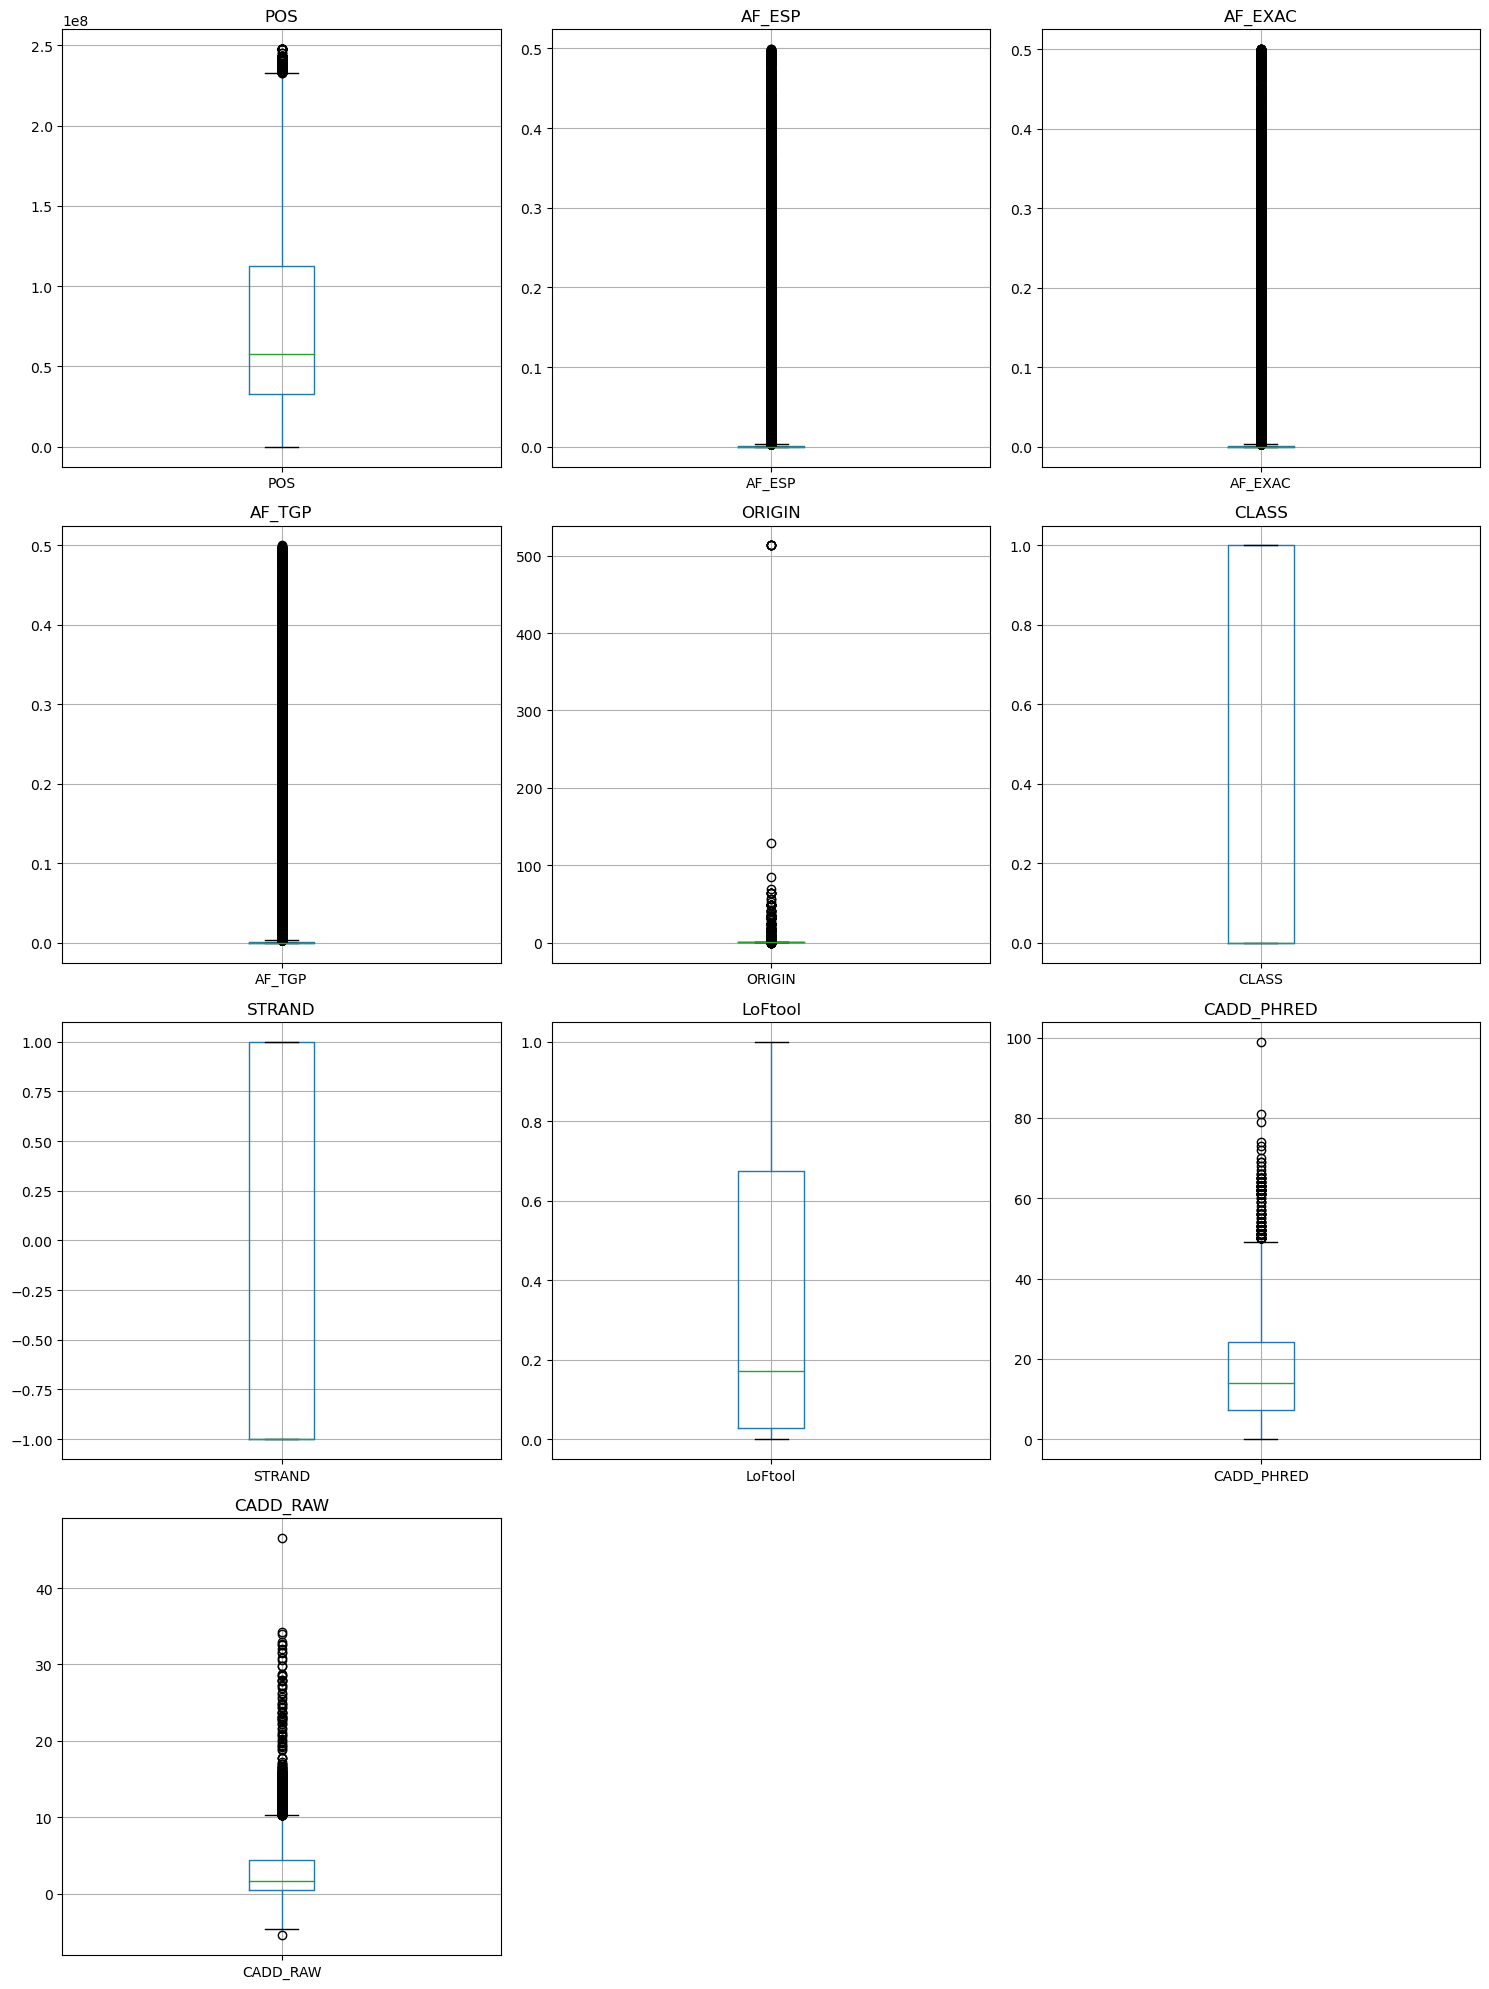

In [71]:
numerical_columns = df.select_dtypes(include=['number']).columns

# Calculate the number of rows and columns for subplots
num_columns = 3
num_rows = (len(numerical_columns) - 1) // num_columns + 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Iterate through numerical columns and plot boxplots
for i, column in enumerate(numerical_columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row][col] if num_rows > 1 else axes[col]  # Adjust if there's only one row
    df.boxplot(column=column, ax=ax)
    ax.set_title(column)

# Remove any empty subplots
for j in range(len(numerical_columns), num_rows * num_columns):
    fig.delaxes(axes.flatten()[j])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

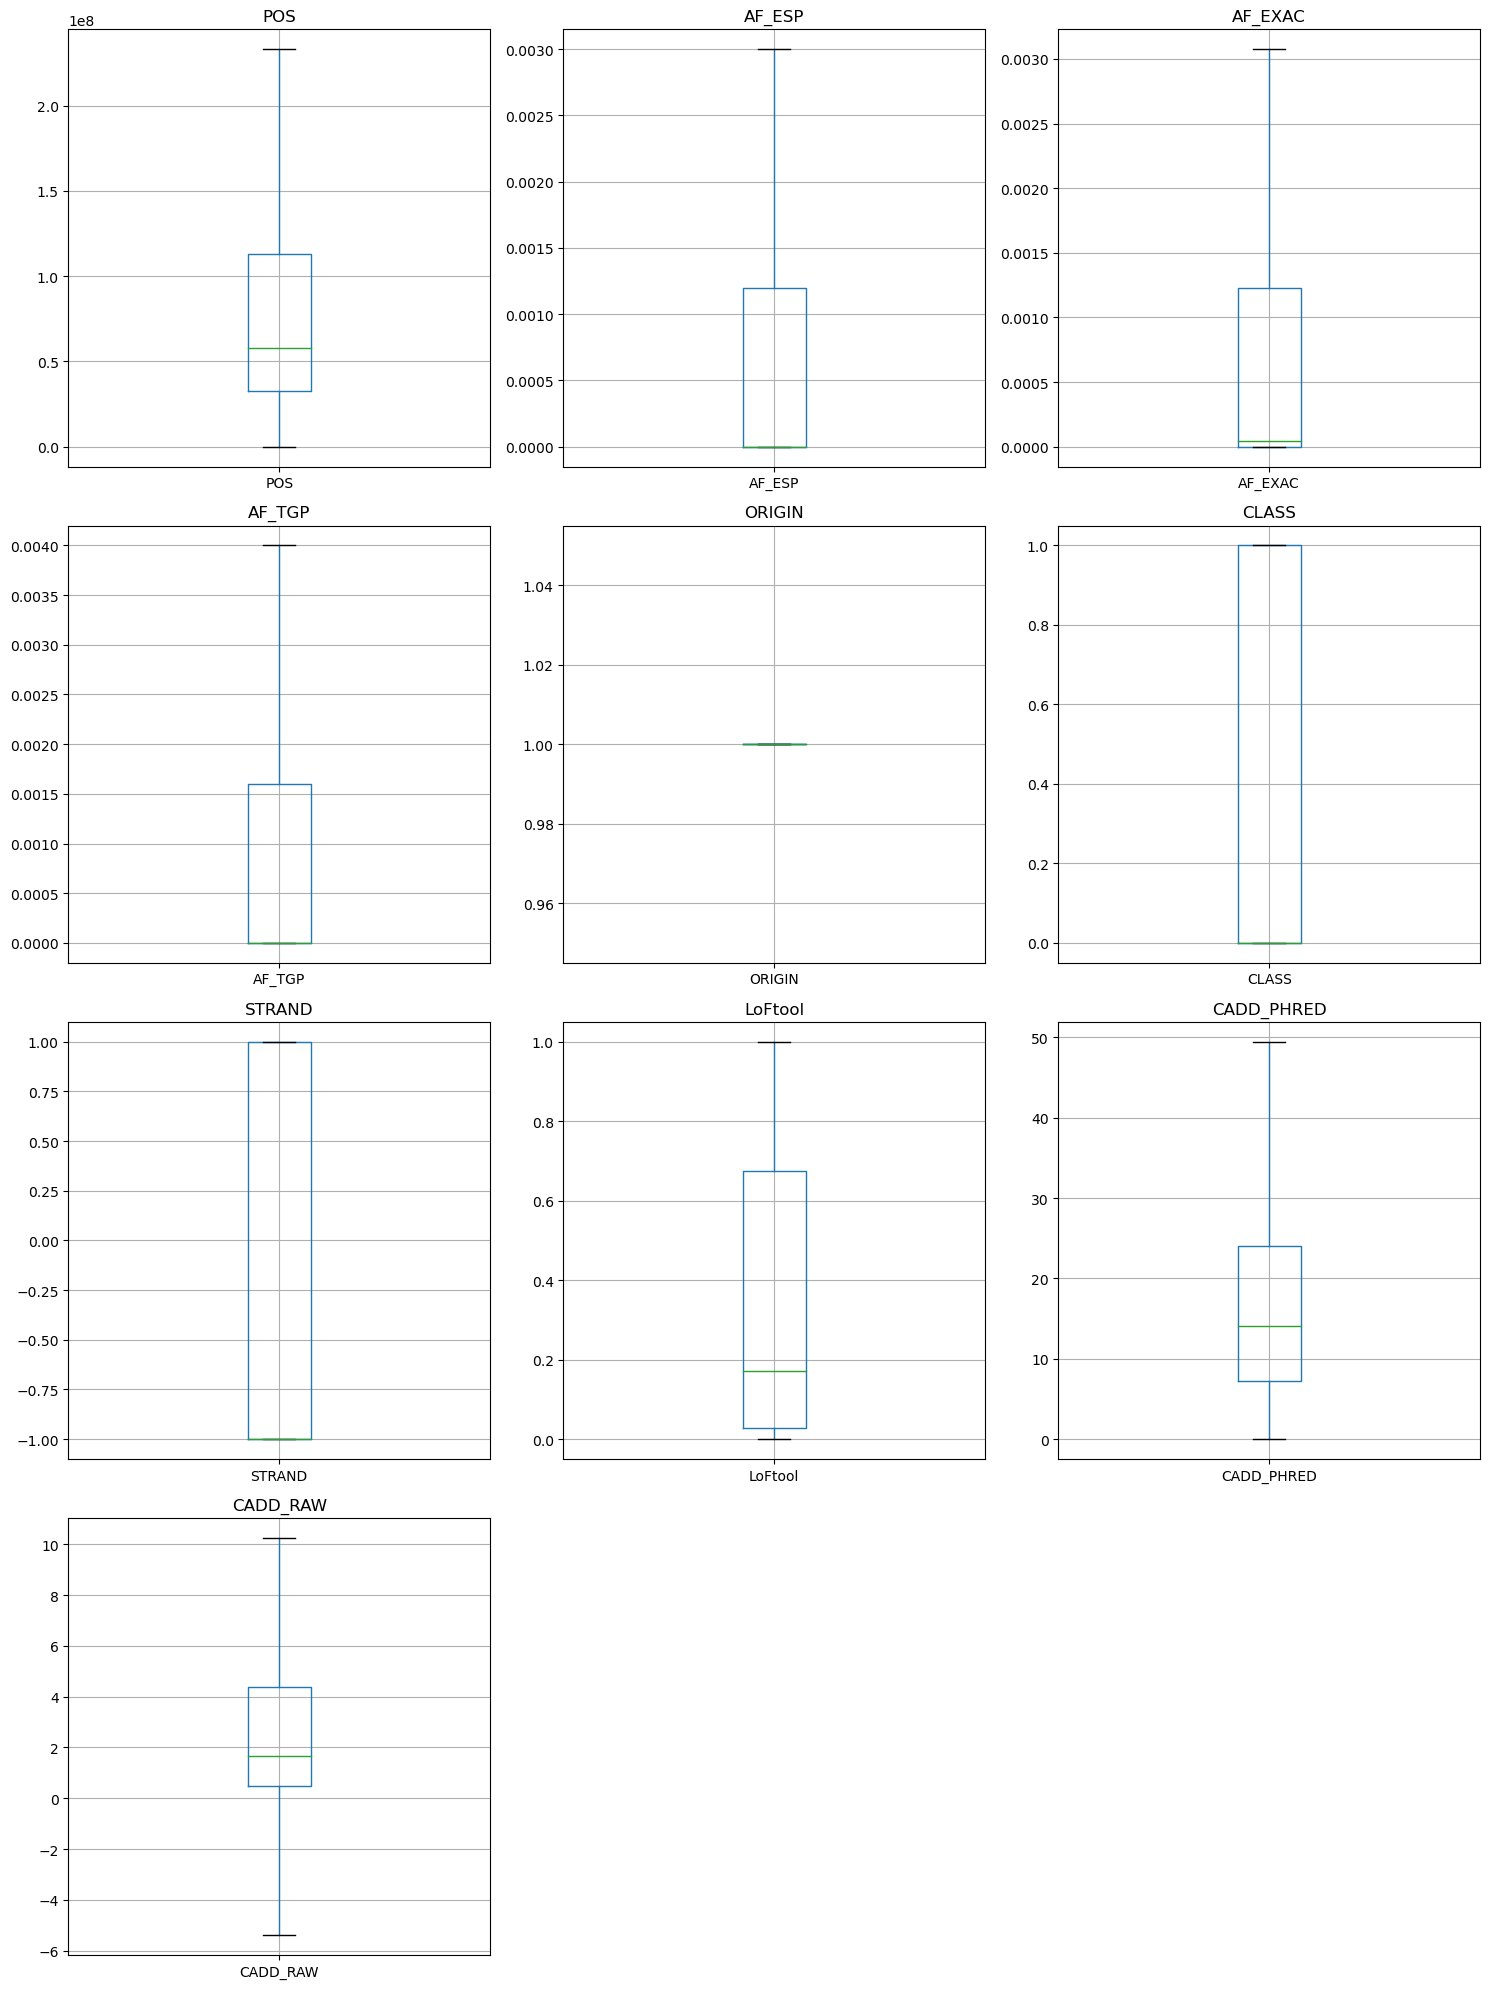

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to cap outliers using IQR
def cap_outliers_iqr(df):
    df_capped = df.copy()
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers for each column
    for column in df.columns:
        df_capped[column] = np.where(df[column] < lower_bound[column], lower_bound[column], df[column])
        df_capped[column] = np.where(df_capped[column] > upper_bound[column], upper_bound[column], df_capped[column])

    return df_capped



# Separate numerical columns
numerical_columns = df.select_dtypes(include=['number'])

# Cap the outliers
df_capped_numerical = cap_outliers_iqr(numerical_columns)

# Fill missing values with the mean of the columns (if there are any missing values)
df_capped_numerical = df_capped_numerical.fillna(df_capped_numerical.mean())

# Update the original DataFrame with capped numerical columns
df_updated = df.copy()
df_updated[numerical_columns.columns] = df_capped_numerical

# Calculate the number of rows and columns for subplots
num_columns = 3
num_rows = (len(numerical_columns.columns) - 1) // num_columns + 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Iterate through columns and plot boxplots
for i, column in enumerate(numerical_columns.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row][col] if num_rows > 1 else axes[col]  # Adjust if there's only one row
    df_updated.boxplot(column=column, ax=ax)
    ax.set_title(column)

# Remove any empty subplots
for j in range(len(numerical_columns.columns), num_rows * num_columns):
    fig.delaxes(axes.flatten()[j])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()





In [73]:
# Assume df_updated is your DataFrame
df_updated = df_updated.dropna()

# Verify that there are no missing values
print(df_updated.isnull().sum())

CHROM               0
POS                 0
REF                 0
ALT                 0
AF_ESP              0
AF_EXAC             0
AF_TGP              0
CLNDISDB            0
CLNDN               0
CLNHGVS             0
CLNVC               0
MC                  0
ORIGIN              0
CLASS               0
Allele              0
Consequence         0
IMPACT              0
SYMBOL              0
Feature_type        0
Feature             0
BIOTYPE             0
EXON                0
cDNA_position       0
CDS_position        0
Protein_position    0
Amino_acids         0
Codons              0
STRAND              0
LoFtool             0
CADD_PHRED          0
CADD_RAW            0
dtype: int64


## Drop unneccsary columns 

In [74]:
result_df= df.drop(['EXON', 'CLNDISDB','Feature',
         'MC','CADD_RAW','CHROM'], axis=1)

In [75]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   POS               65188 non-null  int64  
 1   REF               65188 non-null  object 
 2   ALT               65188 non-null  object 
 3   AF_ESP            65188 non-null  float64
 4   AF_EXAC           65188 non-null  float64
 5   AF_TGP            65188 non-null  float64
 6   CLNDN             65188 non-null  object 
 7   CLNHGVS           65188 non-null  object 
 8   CLNVC             65188 non-null  object 
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  object 
 12  Consequence       65188 non-null  object 
 13  IMPACT            65188 non-null  object 
 14  SYMBOL            65188 non-null  object 
 15  Feature_type      65188 non-null  object 
 16  BIOTYPE           65188 non-null  object

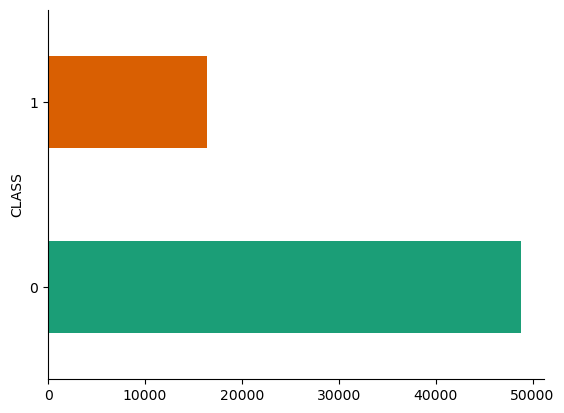

In [76]:
# plot the labels counts
from matplotlib import pyplot as plt
import seaborn as sns
result_df.groupby('CLASS').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)


In [77]:
result_df['CLASS']

0        0
1        0
2        1
3        0
4        0
        ..
65183    0
65184    1
65185    0
65186    0
65187    0
Name: CLASS, Length: 65188, dtype: int64

# Encoding Categorical values  

In [78]:
s_encoder = LabelEncoder()#ref
#chrom_encoder = LabelEncoder()#CHROM
ale_oencoder= LabelEncoder()#alet
CLNHGVS_encoder = LabelEncoder()#  CLNHGVS
CLNDN_encoder = LabelEncoder()#CLNDN
CLNVC_encoder = LabelEncoder()# CLNVC
Allele_encoder = LabelEncoder()#Allele
Consequence_encoder = LabelEncoder()#Consequence
IMPACT_encoder= LabelEncoder()#IMPACT
SYMBOL_encoder = LabelEncoder()#SYMBOL
Feature_type_encoder = LabelEncoder() #Feature_type
BIOTYPE_encoder = LabelEncoder()# BIOTYPE
cDNA_position_encoder=  LabelEncoder()#cDNA_position
CDS_position_encoder = LabelEncoder()#CDS_position
Protein_position_encoder = LabelEncoder()#Protein_position
Amino_acids_encoder = LabelEncoder()# Amino_acids
Codons_encoder = LabelEncoder()# Codons

In [79]:
result_df['REF'] = s_encoder.fit_transform(result_df['REF'])
result_df['ALT'] = ale_oencoder.fit_transform(result_df['ALT'])
result_df['CLNDN'] = CLNDN_encoder.fit_transform(result_df['CLNDN'])
result_df['CLNHGVS'] = CLNHGVS_encoder.fit_transform(result_df['CLNHGVS'])
result_df['CLNVC'] = CLNVC_encoder.fit_transform(result_df['CLNVC'])
result_df['Allele'] = Allele_encoder.fit_transform(result_df['Allele'])
result_df['Consequence'] = Consequence_encoder.fit_transform(result_df['Consequence'])
result_df['IMPACT'] = IMPACT_encoder.fit_transform(result_df['IMPACT'])
result_df['SYMBOL'] = SYMBOL_encoder.fit_transform(result_df['SYMBOL'])
result_df['Feature_type'] = Feature_type_encoder.fit_transform(result_df['Feature_type'])
result_df['BIOTYPE'] = BIOTYPE_encoder.fit_transform(result_df['BIOTYPE'])
result_df['cDNA_position'] = cDNA_position_encoder.fit_transform(result_df['cDNA_position'])
result_df['Protein_position'] =Protein_position_encoder.fit_transform(result_df['Protein_position'])
result_df['CDS_position'] =CDS_position_encoder.fit_transform(result_df['CDS_position'])
result_df['Codons'] =Codons_encoder.fit_transform(result_df['Protein_position'])
result_df['Amino_acids'] =Amino_acids_encoder.fit_transform(result_df['Amino_acids'])

In [80]:
# Calculate mean of 'AF_ESP', 'AF_EXAC', and 'AF_TGP'
result_df['Allele_Freq_Mean'] = result_df[['AF_ESP', 'AF_EXAC', 'AF_TGP']].mean(axis=1)

# Calculate mean of 'LoFtool' and 'CADD_PHRED'
result_df['Pathogenicity_Score_Mean'] = result_df[['LoFtool', 'CADD_PHRED']].mean(axis=1)

In [81]:
#class count
class_count_0, class_count_1 = result_df['CLASS'].value_counts()

# Separate class
class_0 = result_df[result_df['CLASS'] == 0]
class_1 = result_df[result_df['CLASS'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (48754, 27)
class 1: (16434, 27)


## 1.handling calsses unbalance based on calss weights 



## 2.spliting ,fitting and accuracy calculation

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [83]:
imputer = SimpleImputer(strategy='mean')
result_df = pd.DataFrame(imputer.fit_transform(result_df), columns=result_df.columns)

# Separate features and target
X = result_df.drop(['CLASS'], axis=1)
y = result_df['CLASS']

# Define class weights
class_weights = {0: 48754, 1: 16434}

# Calculate the number of samples needed to balance the classes
total_samples = max(class_weights.values())
sampling_strategy = {0: total_samples, 1: total_samples}

# Initialize RandomOverSampler with calculated sampling strategy
oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

# Perform oversampling
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Create DataFrame from the resampled data
result_balanced = pd.DataFrame(X_resampled, columns=X.columns)
result_balanced['CLASS'] = y_resampled

# Now result_balanced contains the oversampled dataset
print(result_balanced['CLASS'].value_counts())

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Print the accuracy score on the test set
accuracy = rf_model.score(X_test, y_test)
print(f"Random Forest accuracy: {accuracy}")
y_pred = model_random.predict(X_test)

# Calculate and print the accuracy
accuracy = model_random.score(X_test, y_test)
print(f"Accuracy Score for random forest model after parameter tuning is: {accuracy * 100:.2f}%")

# Print the classification report
print(classification_report(y_test, y_pred))

CLASS
0.0    48754
1.0    48754
Name: count, dtype: int64
Random Forest accuracy: 0.8828154377328821
Accuracy Score for random forest model after parameter tuning is: 88.35%
              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88     14646
         1.0       0.85      0.94      0.89     14607

    accuracy                           0.88     29253
   macro avg       0.89      0.88      0.88     29253
weighted avg       0.89      0.88      0.88     29253



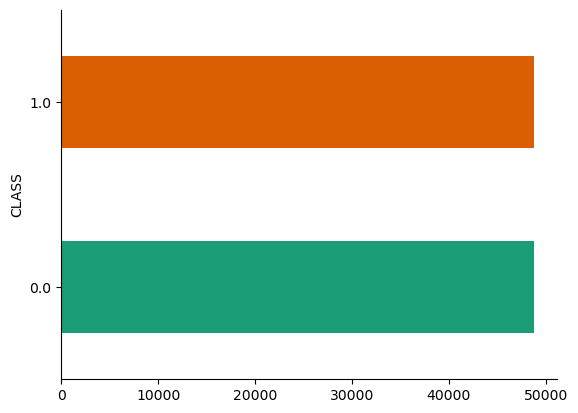

In [84]:
from matplotlib import pyplot as plt
import seaborn as sns
result_balanced.groupby('CLASS').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)


# inference 
in our pervious implementation we used SMOTE techique to handel classes unbalanced which created model with accuracy, =80% 



in our current implemetation wr handled unbalancing based on class weight which resulted in model accuracy we also performed label encoder manually  for specific column and  =88%


## hyper paramter tunning

In [85]:
import warnings
from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV
warnings.filterwarnings("ignore")

In [24]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid with a wider range of values
param_grid_1 = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt'],  # Number of features to consider when looking for the best split 
    'bootstrap': [True],  # Whether bootstrap samples are used
    'class_weight': [None],  # Weights associated with classes
    'min_impurity_decrease': [0.0],  # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
    'random_state': [42]
    
}
# Define the model with the random_state parameter set
model = RandomForestClassifier(random_state=42)

# Define the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid_1, cv=3, n_jobs=-1, verbose=1)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Print the best estimator
print(grid_search.best_estimator_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
RandomForestClassifier(n_estimators=200, random_state=42)


In [36]:
 from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
#Define the model with the best parameters found
model_random = RandomForestClassifier( n_estimators=200, random_state=42)


# Fit the model
model_random.fit(X_train, y_train)

# Predict on the test set
y_pred = model_random.predict(X_test)

# Calculate and print the accuracy
accuracy = model_random.score(X_test, y_test)
print(f"Accuracy Score for random forest model after parameter tuning is: {accuracy * 100:.2f}%")

# Print the classification report
print(classification_report(y_test, y_pred))

Accuracy Score for random forest model after parameter tuning is: 88.35%
              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88     14646
         1.0       0.85      0.94      0.89     14607

    accuracy                           0.88     29253
   macro avg       0.89      0.88      0.88     29253
weighted avg       0.89      0.88      0.88     29253



In [41]:
result_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97508 entries, 0 to 97507
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   POS                       97508 non-null  float64
 1   REF                       97508 non-null  float64
 2   ALT                       97508 non-null  float64
 3   AF_ESP                    97508 non-null  float64
 4   AF_EXAC                   97508 non-null  float64
 5   AF_TGP                    97508 non-null  float64
 6   CLNDN                     97508 non-null  float64
 7   CLNHGVS                   97508 non-null  float64
 8   CLNVC                     97508 non-null  float64
 9   ORIGIN                    97508 non-null  float64
 10  Allele                    97508 non-null  float64
 11  Consequence               97508 non-null  float64
 12  IMPACT                    97508 non-null  float64
 13  SYMBOL                    97508 non-null  float64
 14  Featur

# experiments to enhance hyper paramters tunning 
note this shows  our trailes to find appropriate hyper paramters tunning 
the final result in the previpus cell

# important interpretation
 we suggest that the following  2 trails didnot ehnance model accuracy but the reduced it  because of the type of paramters and the range of values of each paramter to search within for the gridsearch function and randomizedsearch functions
were not 
suitable and we solved this by using get_params function to know the paramters and values of our model therefore identifying paramters and  searching range 

#### trail number1 using grid sreach algorthim 

In [113]:
# Define the parameter grid
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

In [118]:
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X_test, y_test)
print(grid_search.best_estimator_)

In [116]:
model_random = RandomForestClassifier(max_depth=9,
                                      max_features=None,
                                      max_leaf_nodes=9,
                                      n_estimators=150)
model_random.fit(X_train, y_train)
y_pred = model_random .predict(X_test)
print(f"Accuracy Score for randomforest model after paramters tunning is : ",model_random.score(X_test, y_test)*100,"%")


Accuracy Score for randomforest model after paramters tunning is :  67.80842990462517 %


### this resulted in reducing model accuracy from 88% to 67% 


## trail number 2 using randomized search algorthim 

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the model
model = RandomForestClassifier(random_state=42)

# Define the parameter distributions
param_distributions = {
    'n_estimators': randint(50, 200),              # Number of trees in the forest
    'max_features': ['sqrt', 'log2', None],        # Number of features to consider at each split
    'max_depth': [None] + list(range(10, 110, 10)), # Maximum depth of the tree
    'min_samples_split': randint(2, 20),           # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 20),            # Minimum number of samples required at each leaf node
    'bootstrap': [True, False],                    # Whether bootstrap samples are used when building trees
    'oob_score': [True, False],                    # Whether to use out-of-bag samples to estimate the generalization error
    'criterion': ['gini', 'entropy'],              # Function to measure the quality of a split
    'max_leaf_nodes': [None] + list(range(10, 100, 10)), # Maximum number of leaf nodes
    'min_impurity_decrease': uniform(0.0, 0.1),    # Threshold for early stopping in tree growth
    'class_weight': [None, 'balanced'],            # Weights associated with classes
}

# Configure the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=3, 
    n_jobs=-1, 
    verbose=1, 
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters
print(random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 100, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0033532434735779383, 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 54, 'oob_score': True}


In [34]:
 from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
#Define the model with the best parameters found
model_random = RandomForestClassifier(
    bootstrap=True, 
    class_weight=None, 
    criterion='gini', 
    max_depth=100, 
    max_features=None, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0033532434735779383,
    min_samples_leaf=2, 
    min_samples_split=11, 
    n_estimators=54, 
    oob_score=True,
)

# Fit the model
model_random.fit(X_train, y_train)

# Predict on the test set
y_pred = model_random.predict(X_test)

# Calculate and print the accuracy
accuracy = model_random.score(X_test, y_test)
print(f"Accuracy Score for random forest model after parameter tuning is: {accuracy * 100:.2f}%")

# Print the classification report
print(classification_report(y_test, y_pred))

Accuracy Score for random forest model after parameter tuning is: 66.46%
              precision    recall  f1-score   support

         0.0       0.65      0.71      0.68     14646
         1.0       0.68      0.61      0.65     14607

    accuracy                           0.66     29253
   macro avg       0.67      0.66      0.66     29253
weighted avg       0.67      0.66      0.66     29253



### this resulted in reduce model accuracy from 88% to 64%